C:\Users\lg\AppData\Local\Temp\ipykernel_2604\1803114915.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("seg_model.pth", map_location=device)


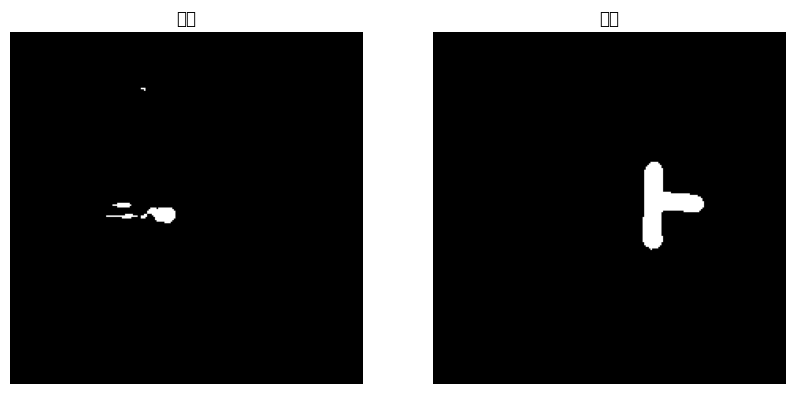

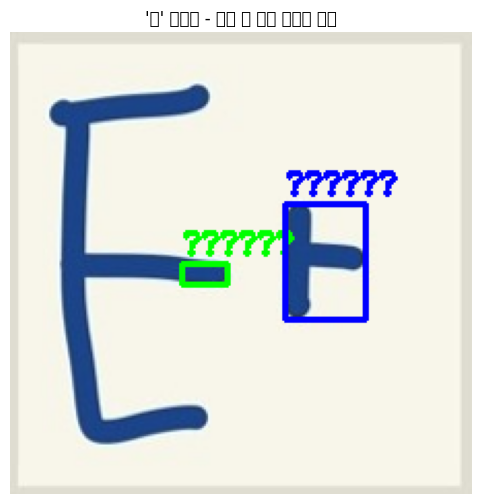

최종 바운딩 박스 좌표: {'초성': (83, 112, 22, 10), '중성': (133, 83, 39, 56)}


In [10]:
import torch
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# ---------------------------
# 1) 모델 로딩 (3클래스)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.FPN(encoder_name="resnext50_32x4d", classes=3)
checkpoint = torch.load("seg_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# ---------------------------
# 2) 테스트 이미지 전처리
# ---------------------------
# 예: "타" 이미지 (종성이 없는 글자)
img_path = "unclear_Ta.png"  
img = Image.open(img_path).convert("RGB")
img = img.resize((224, 224))
img_np = np.array(img)

gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
# 임계값은 상황에 맞게 조정 (여기서는 150로 설정)
ret, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
binary = binary.astype(np.float32) / 255.0
binary_3ch = np.stack([binary, binary, binary], axis=2)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = preprocess(binary_3ch).unsqueeze(0).to(device)

# ---------------------------
# 3) 모델 추론
# ---------------------------
with torch.no_grad():
    output = model(input_tensor)       # (1, 3, 224, 224)
    output = torch.sigmoid(output)
    output_np = output.squeeze(0).cpu().numpy()  # (3, 224, 224)

# ---------------------------
# 4) 강제 반 분할: "타"의 경우 초성은 왼쪽, 중성은 오른쪽만 사용
# ---------------------------
target_letter = "타"
if target_letter in ["타", "비", "자음중성만"]:
    # 우선 초성과 중성 채널만 사용
    mask_choseong = (output_np[0] > 0.5).astype(np.uint8) * 255
    mask_jungseong  = (output_np[1] > 0.5).astype(np.uint8) * 255

    H, W = mask_choseong.shape
    mid = W // 2
    # 초성: 왼쪽 절반만 남김 (오른쪽 반은 0)
    mask_choseong[:, mid:] = 0
    # 중성: 오른쪽 절반만 남김 (왼쪽 반은 0)
    mask_jungseong[:, :mid] = 0

    # 모델 종성 채널은 무시합니다.
    seg_masks = [mask_choseong, mask_jungseong]
    classes = ['초성', '중성']
else:
    # 종성이 포함된 글자는 모든 채널 사용
    seg_masks = (output_np > 0.5).astype(np.uint8) * 255
    classes = ['초성', '중성', '종성']

# 시각화: 강제 반 분할 결과 마스크
fig, ax = plt.subplots(1, len(seg_masks), figsize=(5*len(seg_masks), 5))
if len(seg_masks) == 1:
    ax.imshow(seg_masks[0], cmap='gray')
    ax.set_title(classes[0])
    ax.axis('off')
else:
    for i in range(len(seg_masks)):
        ax[i].imshow(seg_masks[i], cmap='gray')
        ax[i].set_title(classes[i])
        ax[i].axis('off')
plt.show()

# ---------------------------
# 5) 바운딩 박스 추출 (union bounding box)
# ---------------------------
def get_union_bbox(mask, min_area=10):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    xs, ys, xws, yhs = [], [], [], []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        xs.append(x)
        ys.append(y)
        xws.append(x + w)
        yhs.append(y + h)
    if not xs:
        return None
    x_min, y_min = min(xs), min(ys)
    x_max, y_max = max(xws), max(yhs)
    return (x_min, y_min, x_max - x_min, y_max - y_min)

img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
bboxes = {}
colors = [(0, 255, 0), (255, 0, 0)]  # 초성: 초록, 중성: 파랑

for i, cls_name in enumerate(classes):
    mask = seg_masks[i]
    if np.count_nonzero(mask) < 10:
        print(f"[{cls_name}] 영역이 거의 없음")
        bboxes[cls_name] = None
        continue
    bbox = get_union_bbox(mask, min_area=30)
    if bbox is not None:
        bboxes[cls_name] = bbox
        x, y, w, h = bbox
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), colors[i], 2)
        cv2.putText(img_cv, cls_name, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 2)
    else:
        bboxes[cls_name] = None

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title(f"'{target_letter}' 이미지 - 강제 반 분할 바운딩 박스")
plt.axis('off')
plt.show()

print("최종 바운딩 박스 좌표:", bboxes)


C:\Users\lg\anaconda3\envs\Bitamin_25Winter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lg\anaconda3\envs\Bitamin_25Winter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lg\anaconda3\envs\Bitamin_25Winter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12620 (\N{HANGUL LETTER THIEUTH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lg\anaconda3\envs\Bitamin_25Winter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12623 (\N{HANGUL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


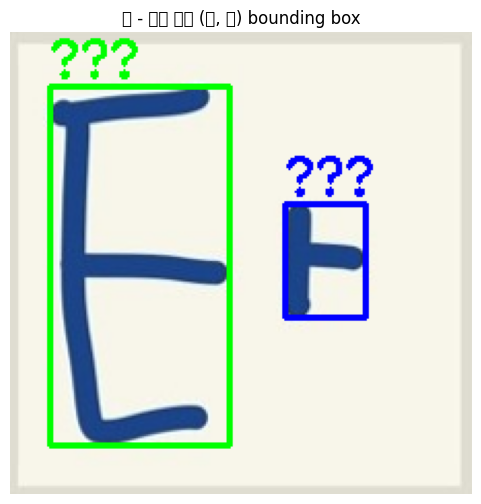

ㅌ 바운딩박스: (19, 26, 87, 174)
ㅏ 바운딩박스: (133, 83, 39, 55)


In [11]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path, thresh_val=150):
    """
    1) 이미지를 RGB -> Grayscale
    2) 임계값(thresh_val)로 이진화(THRESH_BINARY_INV)
    3) 닫기(CLOSE) + 열기(OPEN) 모폴로지 연산을 통해 끊긴 획 연결, 노이즈 제거
    """
    img_pil = Image.open(image_path).convert("RGB")
    img_pil = img_pil.resize((224, 224))  # 크기 통일
    img_np = np.array(img_pil)

    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    # 이진화
    _, binary = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)

    # 모폴로지 연산
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

    return opened  # 최종 이진 마스크

def separate_left_right(mask):
    """
    이미지를 왼쪽/오른쪽으로 분할:
    - 왼쪽: 'ㅌ'으로 간주
    - 오른쪽: 'ㅏ'로 간주
    컨투어를 찾은 뒤, 각 영역을 합쳐서 (x, y, w, h) 바운딩 박스 반환
    """
    H, W = mask.shape
    mid = W // 2

    # 왼쪽/오른쪽 마스크 분할
    left_mask = mask[:, :mid].copy()
    right_mask = mask[:, mid:].copy()

    # 바운딩 박스 구하는 함수 (union)
    def get_union_bbox(m):
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None
        xs, ys, xws, yhs = [], [], [], []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            xs.append(x)
            ys.append(y)
            xws.append(x+w)
            yhs.append(y+h)
        if not xs:
            return None
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)
        return (x_min, y_min, x_max - x_min, y_max - y_min)

    box_left = get_union_bbox(left_mask)
    box_right = get_union_bbox(right_mask)

    # 오른쪽 바운딩박스는 실제 전체 이미지 좌표로 보정 필요
    if box_right is not None:
        x, y, w, h = box_right
        box_right = (x + mid, y, w, h)  # x 좌표 보정

    return box_left, box_right

def visualize_result(img_path, box_left, box_right):
    """
    원본 이미지를 (224x224) 로드해,
    왼쪽 바운딩 박스(ㅌ), 오른쪽 바운딩 박스(ㅏ)를 그려서 시각화
    """
    img_pil = Image.open(img_path).convert("RGB")
    img_pil = img_pil.resize((224, 224))
    img_np = np.array(img_pil)
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # 왼쪽 바운딩 박스 -> 초록
    if box_left is not None:
        x, y, w, h = box_left
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img_cv, "ㅌ", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    # 오른쪽 바운딩 박스 -> 파랑
    if box_right is not None:
        x, y, w, h = box_right
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(img_cv, "ㅏ", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("타 - 좌우 분할 (ㅌ, ㅏ) bounding box")
    plt.axis('off')
    plt.show()

# ---------------------------
# 실제 실행 파트
# ---------------------------
if __name__ == "__main__":
    # 이미지 경로
    image_path = "unclear_Ta.png"  # "E +"

    # 1) 전처리 (이진화 + 모폴로지)
    mask = preprocess_image(image_path, thresh_val=150)

    # 2) 좌/우 분할하여 바운딩박스 추출
    box_t, box_a = separate_left_right(mask)  # (ㅌ, ㅏ) 바운딩박스

    # 3) 결과 시각화
    visualize_result(image_path, box_t, box_a)

    # 좌표 확인
    print("ㅌ 바운딩박스:", box_t)
    print("ㅏ 바운딩박스:", box_a)


In [12]:
def evaluate_bi_bboxes(bboxes, total_img_size=(224,224)):
    """
    bboxes: {'초성':(x, y, w, h), '중성':(x, y, w, h)} 형태.
    total_img_size: 전체 이미지 크기 (width, height)
    
    조건 (예시):
      1. 초성의 y 좌표는 중성의 y 좌표보다 작아야 함.
         (즉, 초성의 top < 중성의 top)
      2. 초성의 바닥(= y + h)은 중성의 바닥보다 작아야 함.
      3. 초성의 높이(h1)는 중성의 높이(h2)의 0.5 ~ 0.8배여야 함.
      4. 초성의 너비(w1)는 중성의 너비(w2)보다 커야 함.
      5. 초성의 x좌표와 y좌표는 각각 20~70 범위에 있어야 함.
      6. 중성의 x좌표와 y좌표는 각각 110~160, 0~50 범위에 있어야 함.
      7. 초성의 높이는 전체 이미지 높이의 30% ~ 50%여야 함.
      8. 중성의 높이는 전체 이미지 높이의 50% ~ 80%여야 함.
      9. 초성의 너비는 전체 이미지 너비의 15% ~ 40%여야 함.
      10. 중성의 너비는 전체 이미지 너비의 0% ~ 35%여야 함.
      
    반환:
      (bool, messages)
      - 모든 조건이 만족하면 (True, [])
      - 하나라도 불만족이면 (False, [문제 메시지들])
    """
    messages = []
    total_w, total_h = total_img_size

    # 필수 바운딩 박스 존재 확인
    if '초성' not in bboxes or '중성' not in bboxes:
        messages.append("초성과 중성 바운딩 박스가 모두 필요합니다.")
        return False, messages

    x1, y1, w1, h1 = bboxes['초성']
    x2, y2, w2, h2 = bboxes['중성']

    # 조건 1: 초성의 y 좌표는 중성의 y 좌표보다 커야함.
    if not (y1 > y2):
        messages.append(f"초성의 y 좌표 ({y1})가 중성의 y 좌표 ({y2})보다 작거나 같습니다.")
        
    # 조건 2: 초성의 바닥(= y1+h1)은 중성의 바닥(= y2+h2)보다 작아야 함.
    if not ((y1 + h1) < (y2 + h2)):
        messages.append(f"초성의 바닥 ({y1+h1})가 중성의 바닥 ({y2+h2})보다 크거나 같습니다.")
    
    # 조건 3: 초성의 높이는 중성의 높이의 0.5~0.8배여야 함.
    if h2 == 0:
        messages.append("중성의 높이가 0입니다.")
    else:
        ratio_h = h1 / h2
        if not (0.4 <= ratio_h <= 0.8):
            messages.append(f"초성의 높이 비율 ({ratio_h:.2f})가 0.4~0.8 범위를 벗어났습니다.")
    
    # 조건 4: 초성의 너비는 중성의 너비보다 커야 함.
    if not (w1 > w2):
        messages.append(f"초성의 너비 ({w1})가 중성의 너비 ({w2})보다 작거나 같습니다.")
    
    # 조건 5: 초성의 x, y 좌표는 각각 20~70
    if not (20 <= x1 <= 70):
        messages.append(f"초성의 x 좌표 ({x1})가 20~70 범위를 벗어났습니다.")
    if not (20 <= y1 <= 70):
        messages.append(f"초성의 y 좌표 ({y1})가 20~70 범위를 벗어났습니다.")
    
    # 조건 6: 중성의 x, y 좌표는 각각 110~160
    if not (110 <= x2 <= 160):
        messages.append(f"중성의 x 좌표 ({x2})가 110~160 범위를 벗어났습니다.")
    if not (0 <= y2 <= 50):
        messages.append(f"중성의 y 좌표 ({y2})가 0~50 범위를 벗어났습니다.")
    
    # 조건 7: 초성의 높이는 전체 이미지 높이의 30% ~ 50%
    if not (0.3 * total_h <= h1 <= 0.5 * total_h):
        messages.append(f"초성의 높이 ({h1})가 전체 높이 ({total_h})의 30%~50% 범위를 벗어났습니다.")
    
    # 조건 8: 중성의 높이는 전체 이미지 높이의 50% ~ 80%
    if not (0.5 * total_h <= h2 <= 0.8 * total_h):
        messages.append(f"중성의 높이 ({h2})가 전체 높이 ({total_h})의 50%~80% 범위를 벗어났습니다.")
    
    # 조건 9: 초성의 너비는 전체 이미지 너비의 15% ~ 40%
    if not (0.15 * total_w <= w1 <= 0.40 * total_w):
        messages.append(f"초성의 너비 ({w1})가 전체 너비 ({total_w})의 15%~40% 범위를 벗어났습니다.")
    
    # 조건 10: 중성의 너비는 전체 이미지 너비의 0% ~ 35%
    if not (0 <= w2 <= 0.35 * total_w):
        messages.append(f"중성의 너비 ({w2})가 전체 너비 ({total_w})의 0%~35% 범위를 벗어났습니다.")
    
    if messages:
        return False, messages
    else:
        return True, []


In [13]:
is_ok, errors = evaluate_bi_bboxes(bboxes, total_img_size=(224,224))

if is_ok:
    print("글씨가 기준 범위 내에 있습니다!")
else:
    print("글씨가 기준을 벗어났습니다. 문제 항목:")
    for e in errors:
        print(" -", e)

글씨가 기준을 벗어났습니다. 문제 항목:
 - 초성의 높이 비율 (0.18)가 0.4~0.8 범위를 벗어났습니다.
 - 초성의 너비 (22)가 중성의 너비 (39)보다 작거나 같습니다.
 - 초성의 x 좌표 (83)가 20~70 범위를 벗어났습니다.
 - 초성의 y 좌표 (112)가 20~70 범위를 벗어났습니다.
 - 중성의 y 좌표 (83)가 0~50 범위를 벗어났습니다.
 - 초성의 높이 (10)가 전체 높이 (224)의 30%~50% 범위를 벗어났습니다.
 - 중성의 높이 (56)가 전체 높이 (224)의 50%~80% 범위를 벗어났습니다.
 - 초성의 너비 (22)가 전체 너비 (224)의 15%~40% 범위를 벗어났습니다.
